## Atmospheric Density Predictions using 1x1 Autoencoder NRLMSISE Data

In [1]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from matplotlib.backends.backend_pdf import PdfPages
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from numpy import loadtxt
from keras.models import load_model, model_from_json
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
import json
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import h5py

Using TensorFlow backend.


### Loading 1x1 filter Autoencoder model

In [2]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [5]:
'''1x1 filter'''
with open('Models/1x1final12.json','r') as f:
    model_encoder_json = json.load(f)
    model_encoder_json = json.dumps(model_encoder_json)
    model_encoder_json = str(model_encoder_json)

model_encoder = model_from_json(model_encoder_json)
model_encoder.load_weights('Models/1x1filter120.h5')
model_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 795)    29415     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 795)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 204)     3243804   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 204)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 934)      4573798   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 934)      4   

In [4]:
encoder_model_1x1 = Model(inputs=model_encoder.input, outputs=model_encoder.layers[8].output)
encoder_model_1x1.summary()

decode_input = Input(model_encoder.layers[9].input_shape[1:])
decoder_model_1x1 = decode_input
for layer in model_encoder.layers[9:]:
    decoder_model_1x1 = layer(decoder_model_1x1)
decoder_model_1x1 = Model(inputs=decode_input, outputs=decoder_model_1x1)

decoder_model_1x1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 795)    29415     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 795)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 204)     3243804   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 204)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 934)      4573798   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 934)      4   

### Load NRLMSISE Density Data if changing out encoder

In [4]:
xdata= np.load("NRLMSISE_concat_data.npy")
xdata_1 = np.log10(xdata)
MSISEstd = np.std(xdata_1, keepdims=True)
MSISEmean = np.mean(xdata_1, keepdims=True)
xmat = (xdata_1 - MSISEmean)/MSISEstd
xmat = np.reshape(xmat, (105192, 24, 20, 36, 1))
sw_data = scipy.io.loadmat("/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/SWdata_NRLMSISE_1997_2008_smooth.mat")
sw_data = sw_data['SWdataFullSmooth']

In [8]:
dens_data = encoder_model_1x1.predict(xmat)

In [9]:
np.save("NRLMSISE_AE_Reduced_data.npy", dens_data)

## Prepare data for training or for testing

In [10]:
#number of hours to predict in the future
pred_number = 48

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
# Training output
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

## Training a new Neural Network in paper's architecture

In [19]:
#deep feed forward network for training
model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])

In [52]:
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0043 - val_accuracy: 0.9969
Epoch 2/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0042 - accuracy: 0.9972 - val_loss: 0.0036 - val_accuracy: 0.9968
Epoch 3/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0041 - accuracy: 0.9972 - val_loss: 0.0061 - val_accuracy: 0.9978
Epoch 4/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0040 - accuracy: 0.9970 - val_loss: 0.0044 - val_accuracy: 0.9971
Epoch 5/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0043 - accuracy: 0.9973 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 6/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0041 - accuracy: 0.9972 - val_loss: 0.0074 - val_accuracy: 0.9968
Epoch 7/500
73614/73614 [==============================] - 2s 

Epoch 56/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0038 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 0.9982
Epoch 57/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0039 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9978
Epoch 58/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9972 - val_loss: 0.0036 - val_accuracy: 0.9974
Epoch 59/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0037 - accuracy: 0.9974 - val_loss: 0.0058 - val_accuracy: 0.9971
Epoch 60/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0026 - val_accuracy: 0.9980
Epoch 61/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0038 - val_accuracy: 0.9975
Epoch 62/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0038 - accuracy: 0.9974

Epoch 111/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.0036 - accuracy: 0.9974 - val_loss: 0.0023 - val_accuracy: 0.9985
Epoch 112/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0039 - accuracy: 0.9975 - val_loss: 0.0090 - val_accuracy: 0.9951
Epoch 113/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0037 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 114/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0037 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9975
Epoch 115/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.0038 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9973
Epoch 116/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0040 - accuracy: 0.9975 - val_loss: 0.0024 - val_accuracy: 0.9986
Epoch 117/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.0037 - accuracy:

Epoch 220/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0037 - accuracy: 0.9975 - val_loss: 0.0064 - val_accuracy: 0.9970
Epoch 221/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9976 - val_loss: 0.0056 - val_accuracy: 0.9974
Epoch 222/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 0.0027 - val_accuracy: 0.9985
Epoch 223/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy: 0.9977 - val_loss: 0.0049 - val_accuracy: 0.9972
Epoch 224/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy: 0.9975 - val_loss: 0.0068 - val_accuracy: 0.9975
Epoch 225/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0033 - accuracy: 0.9976 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 226/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy:

Epoch 329/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 0.0041 - val_accuracy: 0.9963
Epoch 330/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 0.9981
Epoch 331/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0034 - accuracy: 0.9978 - val_loss: 0.0084 - val_accuracy: 0.9970
Epoch 332/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0032 - accuracy: 0.9976 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 333/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0031 - accuracy: 0.9975 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 334/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9974 - val_loss: 0.0044 - val_accuracy: 0.9980
Epoch 335/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0033 - accuracy:

Epoch 438/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9977 - val_loss: 0.0025 - val_accuracy: 0.9984
Epoch 439/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0030 - accuracy: 0.9977 - val_loss: 0.0022 - val_accuracy: 0.9986
Epoch 440/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 0.0030 - val_accuracy: 0.9972
Epoch 441/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9974
Epoch 442/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0030 - accuracy: 0.9979 - val_loss: 0.0029 - val_accuracy: 0.9987
Epoch 443/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9978 - val_loss: 0.0022 - val_accuracy: 0.9982
Epoch 444/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0031 - accuracy:

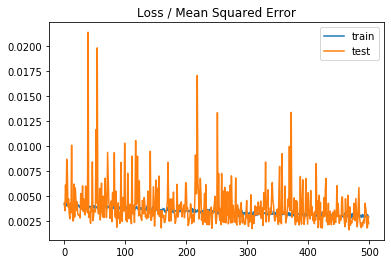

In [54]:
#plots loss of training and validation
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

### Save the most recently trained model

In [55]:
#saves most recent model
model_json = model.to_json()
with open("NN_model_NRLMSISE_1x1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("NN_model_NRLMSISE_1x1.h5")
print("Saved model")

Saved model


### Open the pre trained model

In [11]:
#opens pre-trained model for NRLMSISE AE w/ 1x1 filter
with open('NN_model_NRLMSISE_1x1.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('NN_model_NRLMSISE_1x1.h5')
model_NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 120)               3960      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                820       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

### Feedforward Prediction

[[0.00379368 0.01029233 0.01874252 0.02885543 0.04000561 0.05191825
  0.06454229 0.07757034 0.09090927 0.10457888 0.1184301  0.1324472
  0.14669646 0.16117157 0.1759602  0.19122368 0.20699004 0.22332552
  0.24033811 0.25801522 0.27635018 0.29537464 0.31501331 0.33520884
  0.356064   0.37739567 0.39916802 0.42140956 0.44406006 0.46710278
  0.49057345 0.5144458  0.53873704 0.56349352 0.58871931 0.61441287
  0.64059064 0.66725147 0.69437592 0.721947   0.74993033 0.77825463
  0.80683888 0.83557406 0.86438158 0.89318741 0.9218848  0.95043276]]
[[ 19.10553    18.966751   18.85283    18.643108   18.383034   18.147081
   17.949709   17.744957   17.608389   17.53042    17.497986   17.502369
   17.551073   17.628382   17.745964   17.902687   18.081959   18.265177
   18.425684   18.420507   18.37832    18.289408   18.090328   17.852219
   17.572794   16.87107    16.320345   15.773134   15.185959   14.663065
   14.185282   13.848141   13.575428   13.368191   13.135918   12.9716625
   12.868111   1

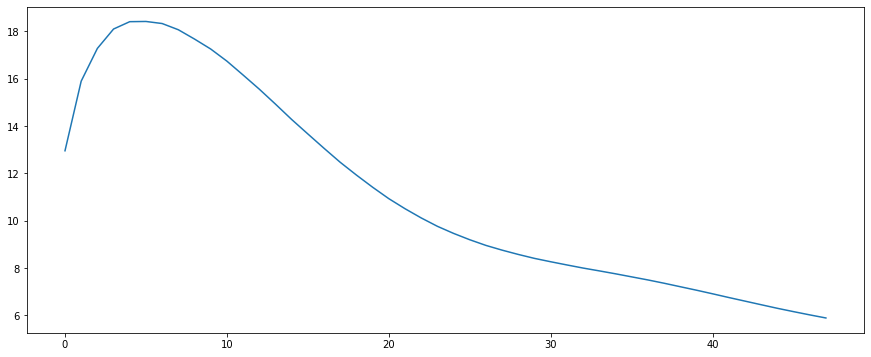

In [12]:
#predicts pred_number hours into the future 
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))

NN_prediction = None
DMDc_prediction = None

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN) #change to model if using own training
    if not b: NN_prediction = np.reshape(y_pred[-1,:],(10,1))
    else: NN_prediction = np.append(NN_prediction, np.reshape(y_pred[-1,:],(10,1)),axis = 1)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_NN[0][b] = np.sum(np.square(y_test_NN-y_pred))/(y_pred.shape[1]*y_pred.shape[0])
    mse2 = np.sum(np.square(y_pred-y_test_NN),axis = 1)
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 
NN_prediction = NN_prediction.T

for a in range(pred_number):
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0): x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    if not a: DMDc_prediction = np.reshape(XfullPred[-1,:],(10,1))
    else: DMDc_prediction = np.append(DMDc_prediction, np.reshape(XfullPred[-1,:],(10,1)),axis = 1)
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_ROM[0][a] = np.sum(np.square(errFullPred))/(errFullPred.shape[1]*errFullPred.shape[0])
    mse_rom2 = np.sum(np.square(errFullPred),axis = 1)
    
print(mse_ROM) 

DMDc_prediction = DMDc_prediction.T

factor = np.divide(np.transpose(mse_ROM), np.transpose(mse_NN))
plt.figure(figsize = (15,6))
plt.plot(factor)

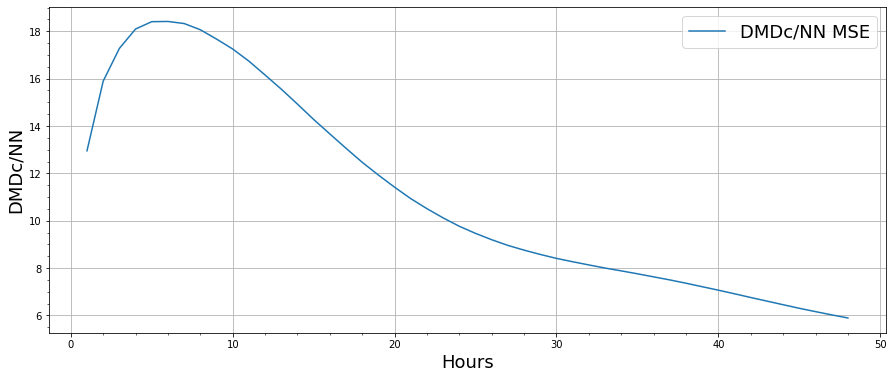

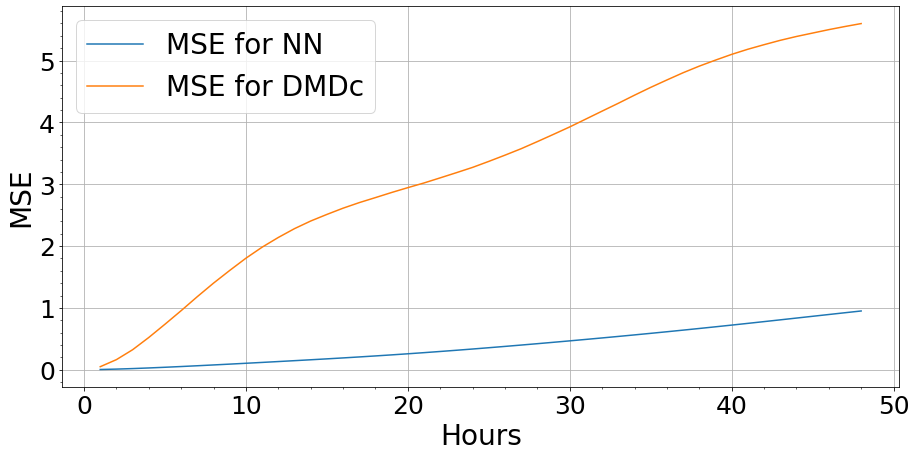

In [14]:
plt.figure(figsize = (15,6))
plt.title("NRLMSISE 1997-2008: DMDc/NN MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),factor, label = "DMDc/NN MSE")
plt.grid()
plt.minorticks_on()
plt.legend(fontsize=18)
plt.xlabel("Hours", fontsize=18)
plt.ylabel("DMDc/NN", fontsize=18)
#plt.savefig('1x1_AE_DMDc/NN_Ratio.png')  

plt.figure(figsize = (15,7))
plt.title("NRLMSISE 1997-2008: Comparison of MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
plt.xlabel("Hours",fontsize=28)
plt.ylabel("MSE",fontsize=28)
plt.legend(fontsize=28)
plt.xticks(size = 25)
plt.yticks(size = 25)
#plt.savefig('1x1_AE_NRLMSISE_both_48.png')


## Making predictions only using Previous timestep

In [17]:
x_test_NN = x_test[0,:]
x_test_NN= np.reshape(x_test_NN, (1, 32))
x_test_rom = np.reshape(x_test[0,:10], (1, 10))

NN_prediction = None
for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    if b == 0:
        NN_prediction = y_pred
    else:
        NN_prediction = np.append(NN_prediction, y_pred, axis = 0)
    sw_data_test = np.reshape(sw_data[b,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[b+1,:],(1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)
    
DMDc_prediction = None
for a in range(pred_number):
    #General
    sw_data_test = np.reshape(sw_data[a,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[a+1,:], (1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_rom = np.transpose(np.matmul(A,np.transpose(x_test_rom)) + np.matmul(B,np.transpose(sw_data_test)))
    if not a:
        DMDc_prediction = x_test_rom
    else:
        DMDc_prediction = np.append(DMDc_prediction, x_test_rom, axis = 0)


In [43]:
nndecoded = None
DMDcdecoded = None
for i in range(1,pred_number+1):
    nn_data = NN_prediction[i-1:i,:]
    decoded_nn = decoder_model_1x1.predict(nn_data)
    DMDc_data = DMDc_prediction[i-1:i,:]
    decoded_DMDc = decoder_model_1x1.predict(DMDc_data)
    if i == 1:
        nndecoded = decoded_nn
        DMDcdecoded = decoded_DMDc
    else:
        nndecoded = np.append(nndecoded, decoded_nn, axis = 0)
        DMDcdecoded = np.append(DMDcdecoded, decoded_DMDc, axis = 0)

In [44]:
nndecoded = nndecoded*MSISEstd + MSISEmean
DMDcdecoded = DMDcdecoded*MSISEstd + MSISEmean
tens = np.full((48,17280), 10)
nndecoded = np.power(tens, nndecoded)
DMDcdecoded = np.power(tens, DMDcdecoded)

In [45]:
actual = xdata[split_15-pred_number:split_15,:]
nn_error = np.sum(np.square(nndecoded-actual))/(actual.shape[0]*actual.shape[1])
dmdc_error = np.sum(np.square(DMDcdecoded-actual))/(actual.shape[0]*actual.shape[1])

3.1410012112206796e-16
2.1445691216988474e-16
[5.3729860e-07 5.3704758e-07 5.3672994e-07 5.3632800e-07 5.3582653e-07]
[3.95792809e-07 3.91045220e-07 3.93803611e-07 3.99241673e-07
 3.96252410e-07]
[4.17223230e-07 4.13560906e-07 4.15972680e-07 4.21226353e-07
 4.17627464e-07]


/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

<Figure size 432x288 with 0 Axes>

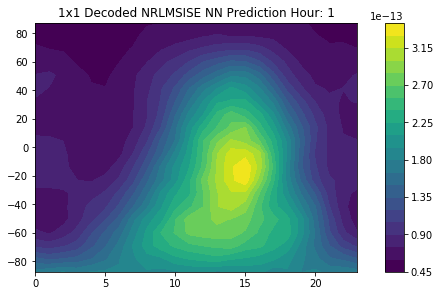

<Figure size 432x288 with 0 Axes>

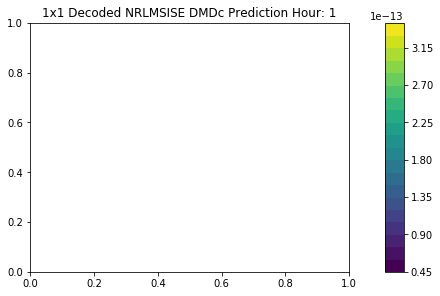

<Figure size 432x288 with 0 Axes>

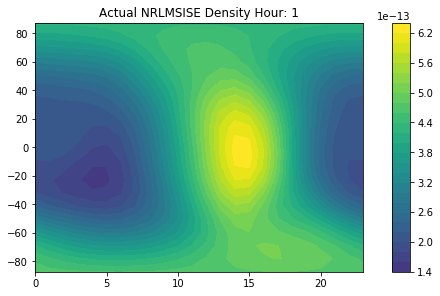

<Figure size 432x288 with 0 Axes>

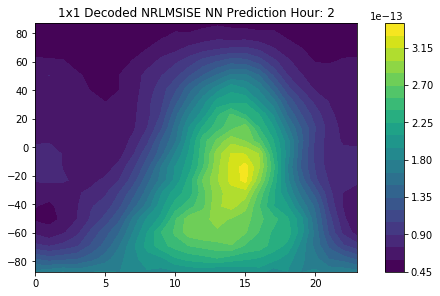

<Figure size 432x288 with 0 Axes>

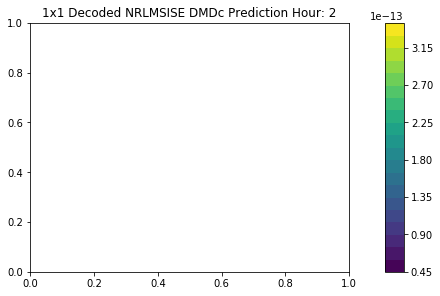

<Figure size 432x288 with 0 Axes>

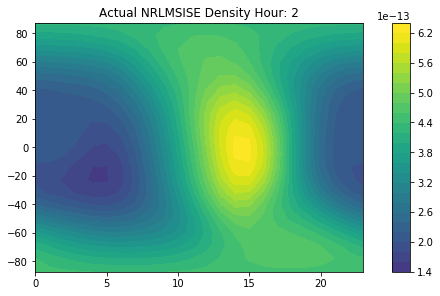

<Figure size 432x288 with 0 Axes>

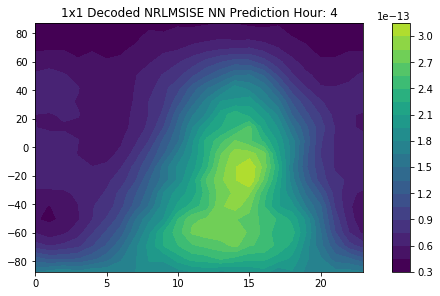

<Figure size 432x288 with 0 Axes>

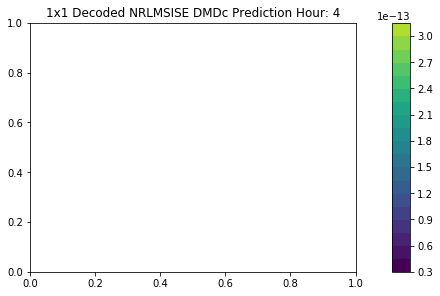

<Figure size 432x288 with 0 Axes>

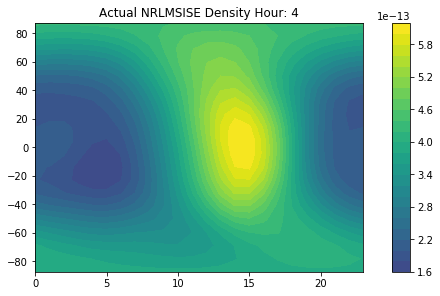

<Figure size 432x288 with 0 Axes>

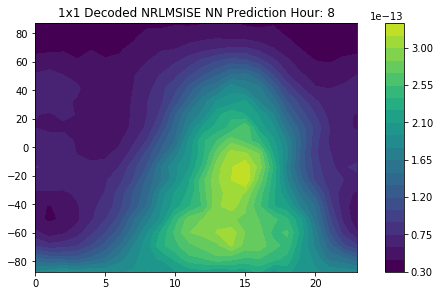

<Figure size 432x288 with 0 Axes>

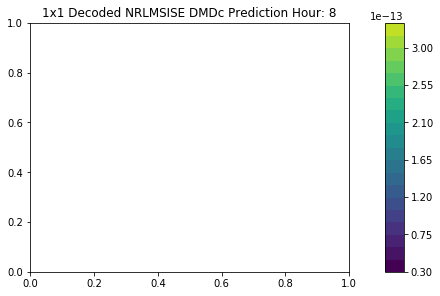

<Figure size 432x288 with 0 Axes>

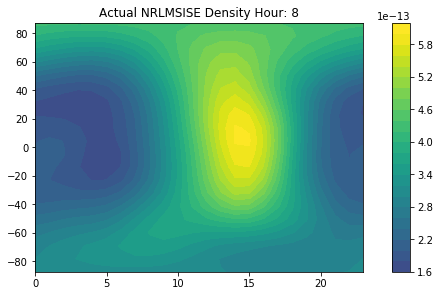

<Figure size 432x288 with 0 Axes>

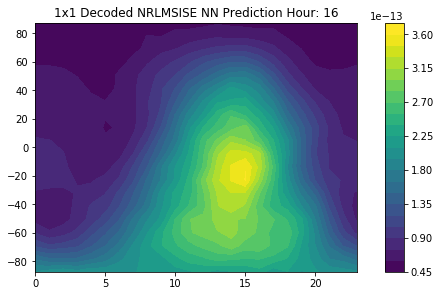

<Figure size 432x288 with 0 Axes>

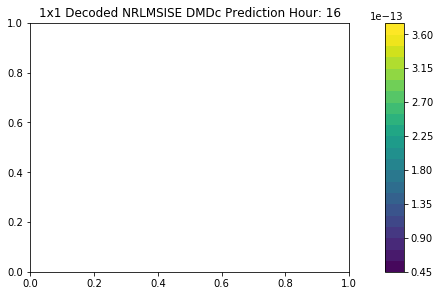

<Figure size 432x288 with 0 Axes>

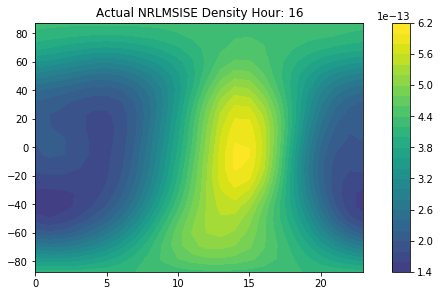

<Figure size 432x288 with 0 Axes>

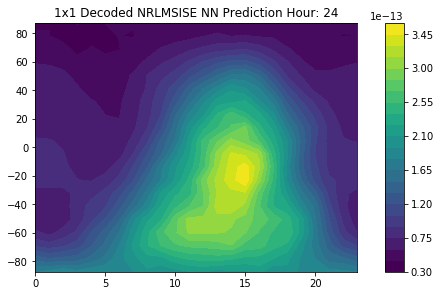

<Figure size 432x288 with 0 Axes>

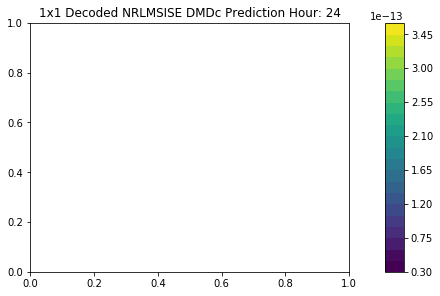

<Figure size 432x288 with 0 Axes>

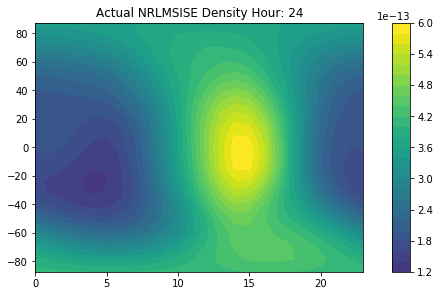

In [47]:
hours = [0,3,7,11,15,19,23] #Prediction hours

cols = len(hours)
rows = 5
fig = plt.figure(figsize = (36,20))

for h in range(len(hours)):
    hr = hours[h]
    nndecoded_1 = np.reshape(densityNNPred[hr,:], (24, 20, 36), order = "f")
    DMDcdecoded_1 = np.reshape(densityDMDcPred[hr,:], (24, 20, 36), order = "f")
    actual_1 = np.reshape(actualPred[hr,:], (24, 20, 36), order = "f")
    nn_error = np.reshape(densityNNPred_Error[hr,:], (24, 20, 36), order = "f") #np.divide((nndecoded_1-actualPred_1),actualPred_1)
    dmdc_error = np.reshape(densityDMDcPred_Error[hr,:], (24, 20, 36), order = "f") # np.divide((DMDcdecoded_1-actualPred_1),actualPred_1)
    plt.figure()

    ax1 = fig.add_subplot(rows, cols, h+1)
    CS1 = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, actual_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax1.set_ylabel('a)     ', fontsize=40,rotation='horizontal')
    ax1.axes.xaxis.set_visible(False)
    ax1.get_yaxis().set_ticks([])
    if h: 
        ax1.axes.yaxis.set_visible(False)
   
    ax2 = fig.add_subplot(rows, cols, h+1+cols*1)
    CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nndecoded_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax2.set_ylabel('b)     ', fontsize=40,rotation='horizontal')
    ax2.axes.xaxis.set_visible(False)
    ax2.get_yaxis().set_ticks([])
    if h:
        ax2.axes.yaxis.set_visible(False)
    
    ax3 = fig.add_subplot(rows,cols,h+1+cols*2)
    CS3 = ax3.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, DMDcdecoded_1[:,:,18].T, levels = 25, vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    if not h: ax3.set_ylabel('c)     ', fontsize=40,rotation='horizontal')
    ax3.axes.xaxis.set_visible(False)
    ax3.get_yaxis().set_ticks([])
    if h:
        ax3.axes.yaxis.set_visible(False)
    
    ax1 = fig.add_subplot(rows,cols,h+1+cols*3)
    CS = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nn_error[:,:,18].T, cmap = "jet",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    if not h: 
        ax1.set_ylabel('d)     ', fontsize=40,rotation='horizontal')
    ax1.axes.xaxis.set_visible(False)
    ax1.get_yaxis().set_ticks([])
    if h:
        ax1.axes.yaxis.set_visible(False)
    
    ax2 = fig.add_subplot(rows,cols,h+1+cols*4)
    CS = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, dmdc_error[:,:,18].T, cmap = "jet",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    if not h: ax2.set_ylabel('e)     ', fontsize=40,rotation='horizontal')
    ax2.axes.xaxis.set_visible(False)
    ax2.get_yaxis().set_ticks([])
    if h:
        ax2.axes.yaxis.set_visible(False)
#Run to save figure    
#fig.savefig("NRLMSISE_1x1_DMDc_168_RB.png")
